In [108]:
import math
import matplotlib
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt

from pylab import rcParams
#np.warnings.filterwarnings('ignore')

%matplotlib inline

#### Input params ##################
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 21                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14
####################################
# import necessary modulus for manipulation
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#import urlib.requesst to open URLs
from urllib.request import urlopen 

#import Beautiful Soup package to extract data from html fles
from bs4 import BeautifulSoup
import re

#import necessary modules for data visualization
from pylab import rcParams
import seaborn as sns, numpy as np
#The machine learning code is extracted from the following resouces:
# Yibin Ng (2019, Jan 27). 
# https://courses.analyticsvidhya.com/courses/take/creating-time-series-forecast-using-python/surveys/6238171-your-feedback

In [109]:
url="https://finance.yahoo.com/quote/AAPL/history?period1=1539327600&period2=1570863600&interval=1d&filter=history&frequency=1d" #open link
html = urlopen(url)

In [110]:
soup = BeautifulSoup(html, 'lxml')

In [111]:
data = []
allrows= soup.find_all("tr")
for row in allrows :
    row_list = row.find_all("td")
    dataRow= []
    for cell in row_list:
        dataRow.append(cell.text)
    data.append(dataRow)
  
data = data[1:] 

In [112]:
#Check the data header to see if this is the what we want 
header_list = []
col_headers = soup.find_all('th')
for col in col_headers:
    header_list.append(col.text)
print(header_list)

['Date', 'Open', 'High', 'Low', 'Close*', 'Adj Close**', 'Volume']


In [113]:
#Use pandas to make data frame
df = pd.DataFrame(data)

In [114]:
#Check data head and tail to ensure the dataframe is correct
df.columns = header_list
print(df.head())
print(df.tail())

           Date    Open    High     Low  Close* Adj Close**      Volume
0  Oct 11, 2019  232.95  237.64  232.31  236.21      236.21  41,698,900
1  Oct 10, 2019  227.93  230.44  227.30  230.09      230.09  28,253,400
2  Oct 09, 2019  227.03  227.79  225.64  227.03      227.03  18,692,600
3  Oct 08, 2019  225.82  228.06  224.33  224.40      224.40  27,955,000
4  Oct 07, 2019  226.27  229.93  225.84  227.06      227.06  30,576,500
                                                  Date    Open    High  \
96                                        May 29, 2019  176.42  179.35   
97                                        May 28, 2019  178.92  180.59   
98                                        May 24, 2019  180.20  182.14   
99                                        May 23, 2019  179.80  180.54   
100  *Close price adjusted for splits.**Adjusted cl...    None    None   

        Low  Close* Adj Close**      Volume  
96   176.00  177.38      176.71  28,481,200  
97   177.91  178.23      177.56

In [115]:
#check data shape
df.shape

(101, 7)

In [80]:
#check data and drop na data
df2 = df.dropna(how='any')
df.shape

(101, 7)

In [81]:
#print(df)

In [82]:
df = df[df.Open.str.contains("Dividend") == False] 

In [83]:
from time import strptime

df['Date'] = pd.to_datetime(df['Date'])

In [84]:
print(df.head())

        Date    Open    High     Low  Close* Adj Close**      Volume
0 2019-10-11  232.95  237.64  232.31  236.21      236.21  41,698,900
1 2019-10-10  227.93  230.44  227.30  230.09      230.09  28,253,400
2 2019-10-09  227.03  227.79  225.64  227.03      227.03  18,692,600
3 2019-10-08  225.82  228.06  224.33  224.40      224.40  27,955,000
4 2019-10-07  226.27  229.93  225.84  227.06      227.06  30,576,500


In [85]:
#df = df[df.Open.str.contains("Dividend") == False] 

In [86]:
# df['date']=pd.to_datetime(df['Date'])

In [87]:
def get_preds_mov_avg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Using simple moving average.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : list. The predictions for target_col. np.array of length len(df)-offset.
    """
    pred_list = df[target_col].rolling(window = N, min_periods=1).mean() # len(pred_list) = len(df)
    
    # Add one timestep to the predictions
    pred_list = np.concatenate((np.array([np.nan]), np.array(pred_list[:-1])))
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
    
    return pred_list[offset:]

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [88]:
def get_preds_mov_avg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Using simple moving average.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : list. The predictions for target_col. np.array of length len(df)-offset.
    """
    pred_list = df[target_col].rolling(window = N, min_periods=1).mean() # len(pred_list) = len(df)
    
    # Add one timestep to the pr=edictions
    pred_list = np.concatenate((np.array([np.nan]), np.array(pred_list[:-1])))
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
    
    return pred_list[offset:]

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [89]:
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
df.head(10)

,date,open,high,low,close*,adj_close**,volume
0,2019-10-11,232.95,237.64,232.31,236.21,236.21,"41,698,900"
1,2019-10-10,227.93,230.44,227.30,230.09,230.09,"28,253,400"
2,2019-10-09,227.03,227.79,225.64,227.03,227.03,"18,692,600"
3,2019-10-08,225.82,228.06,224.33,224.40,224.40,"27,955,000"
4,2019-10-07,226.27,229.93,225.84,227.06,227.06,"30,576,500"
5,2019-10-04,225.64,227.49,223.89,227.01,227.01,"34,619,700"
6,2019-10-03,218.43,220.96,215.13,220.82,220.82,"28,606,500"
7,2019-10-02,223.06,223.58,217.93,218.96,218.96,"34,612,300"
8,2019-10-01,225.07,228.22,224.20,224.59,224.59,"34,805,800"
9,2019-09-30,220.90,224.58,220.79,223.97,223.97,"25,977,400"


In [90]:
df['close'] = df['close*']
df['adj_close'] = df['adj_close**']
# Change data to numeric data
df['adj_close'] = pd.to_numeric(df['adj_close'])

Text(0, 0.5, 'USD')

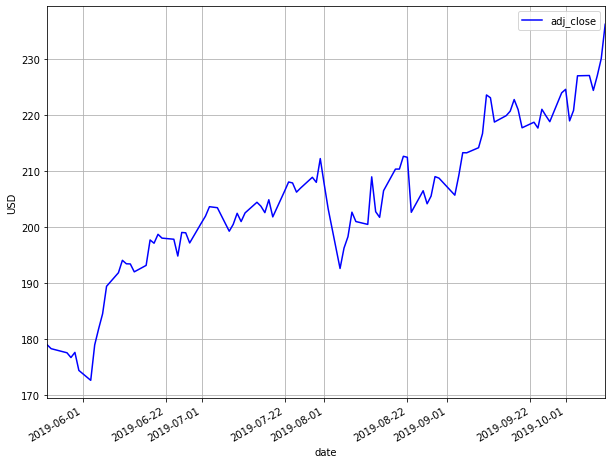

In [91]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [92]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 61
num_cv = 19
num_test = 19
train.shape = (61, 9)
cv.shape = (19, 9)
train_cv.shape = (80, 9)
test.shape = (19, 9)


Text(0, 0.5, 'USD')

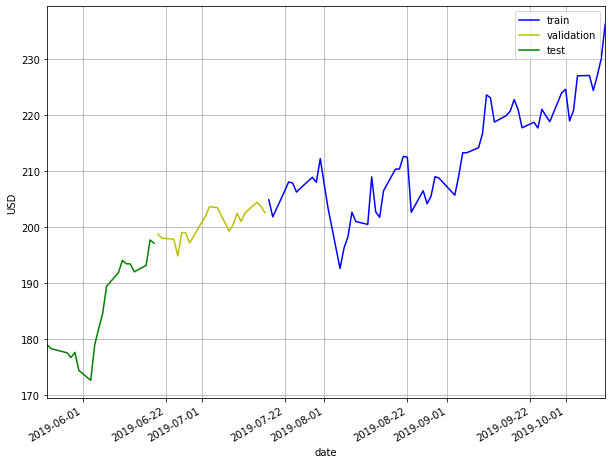

In [93]:
#Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [94]:
RMSE = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_mov_avg(train_cv, 'adj_close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj_close'])))
    mape.append(get_mape(cv['adj_close'], est_list))
print('RMSE = ' + str(RMSE))
print('MAPE = ' + str(mape))
df.head()

C:\Users\gladies\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
C:\Users\gladies\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\gladies\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\gladies\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invali

RMSE = [2.1290979063295836, 2.0873683381107724, 2.0484308643075915, 2.194374311374601, 2.283671559019232, 2.350592279475016, 2.47230407370696, 2.5785538997305455, 2.6966646185569396, 2.900141430307905, 3.0685169407623794, 3.184791590994702, 3.255957757035951, 3.3316373146790434, 3.4202075857796177, 3.506991029559962, 3.5577662631346283, 3.5973453545273038, 3.638633384745848, 3.6790195078951853, 3.7389191451899952]
MAPE = [0.8703183348264196, 0.8538219947406845, 0.8058781031723179, 0.8738320031612538, 0.9173004705446339, 0.9545790128825427, 1.0077363843301295, 1.075868304116168, 1.1578609753579536, 1.2555937587051034, 1.3380442378596415, 1.3886530939585895, 1.412547061037077, 1.4367658503372256, 1.4612590847289086, 1.489403213958373, 1.5087879698769202, 1.5252044281116377, 1.5542692672189597, 1.5789946695067751, 1.5807001142097519]


,date,open,high,low,close*,adj_close**,volume,close,adj_close
0,2019-10-11,232.95,237.64,232.31,236.21,236.21,"41,698,900",236.21,236.21
1,2019-10-10,227.93,230.44,227.30,230.09,230.09,"28,253,400",230.09,230.09
2,2019-10-09,227.03,227.79,225.64,227.03,227.03,"18,692,600",227.03,227.03
3,2019-10-08,225.82,228.06,224.33,224.40,224.40,"27,955,000",224.40,224.40
4,2019-10-07,226.27,229.93,225.84,227.06,227.06,"30,576,500",227.06,227.06


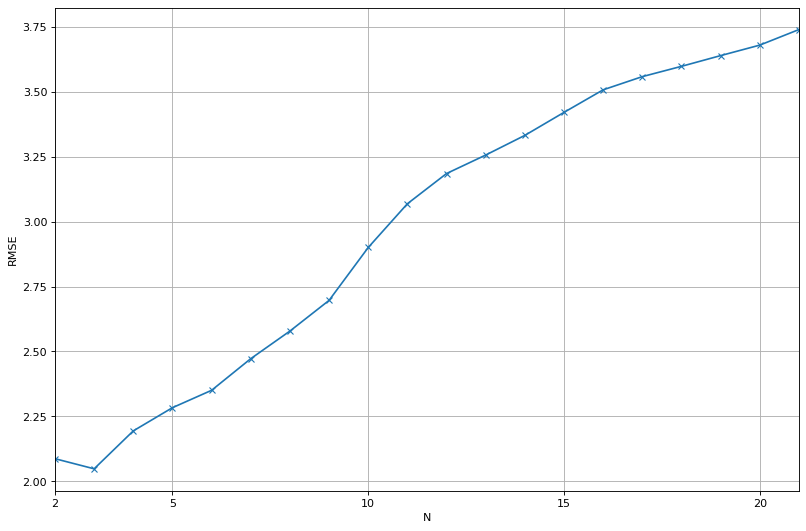

In [95]:
# Plot RMSE versus N
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 21])
plt.xticks([2, 5, 10, 15, 20])
matplotlib.rcParams.update({'font.size': 14})

([<matplotlib.axis.XTick at 0x20e0b0bb898>,
 <a list of 5 Text xticklabel objects>)

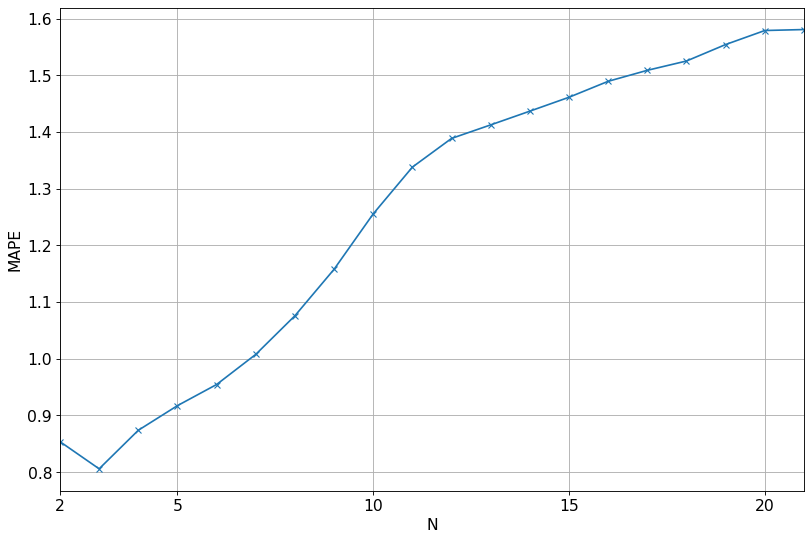

In [96]:
# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')
plt.xlim([2, 21])
plt.xticks([2, 5, 10, 15, 20])

In [97]:
# Set optimum N
N_opt = 2

Text(0, 0.5, 'USD')

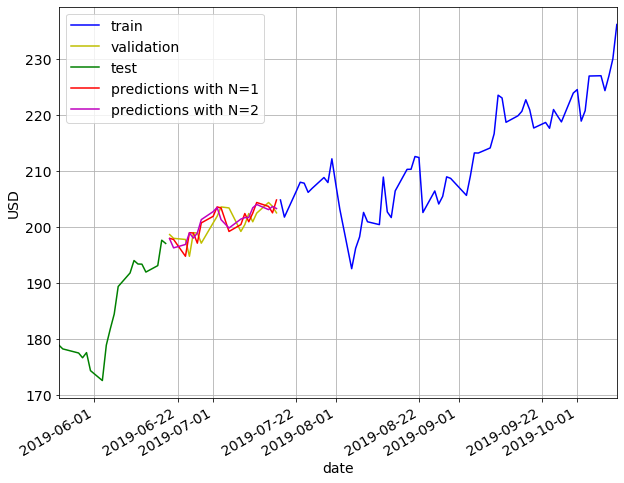

In [98]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='m-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

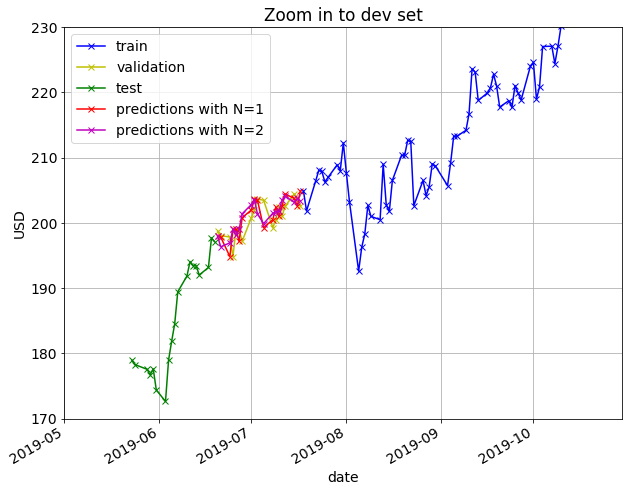

In [99]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2019, 5, 1), date(2019, 10, 30)])
ax.set_ylim([170, 230])
ax.set_title('Zoom in to dev set')

In [100]:
est_list = get_preds_mov_avg(df, 'adj_close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['adj_close'])))
print("MAPE = %0.3f%%" % get_mape(test['adj_close'], est_list))
test.head()

C:\Users\gladies\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
C:\Users\gladies\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\gladies\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


RMSE = 3.347
MAPE = 1.404%


,date,open,high,low,close*,adj_close**,volume,close,adj_close,est_N2
81,2019-06-19,199.68,199.88,197.31,197.87,197.12,"21,124,200",197.87,197.12,198.370
82,2019-06-18,196.05,200.29,195.21,198.45,197.70,"26,551,000",198.45,197.70,197.915
83,2019-06-17,192.90,194.96,192.17,193.89,193.16,"14,669,100",193.89,193.16,197.410
84,2019-06-14,191.55,193.59,190.30,192.74,192.01,"18,761,500",192.74,192.01,195.430
85,2019-06-13,194.70,196.79,193.60,194.15,193.42,"21,674,600",194.15,193.42,192.585


Text(0, 0.5, 'USD')

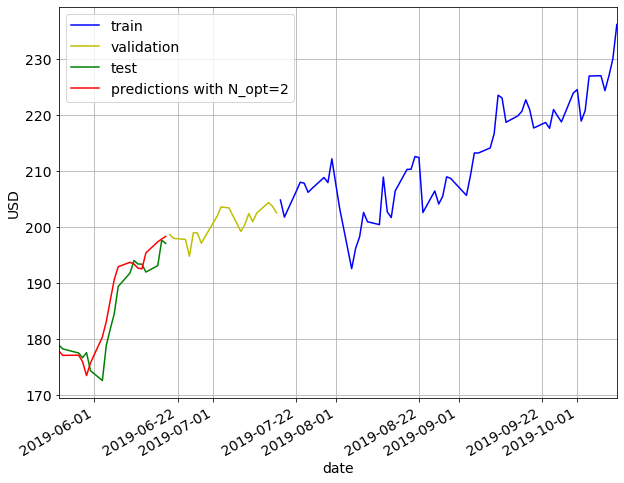

In [101]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N2', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

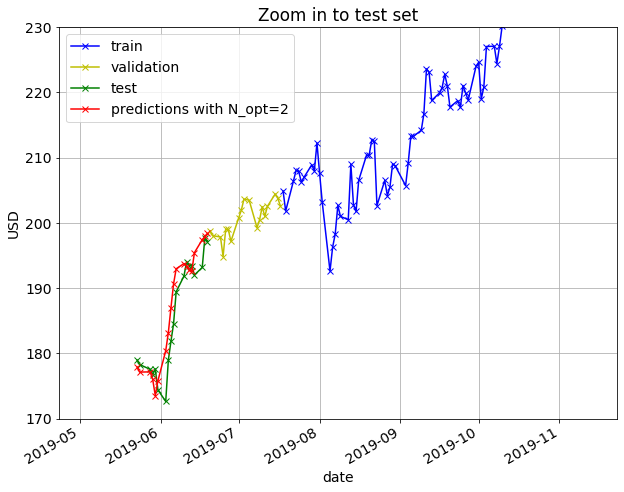

In [102]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N2', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2019, 4, 23), date(2019, 11, 23)])
ax.set_ylim([170, 230])
ax.set_title('Zoom in to test set')

(170, 230)

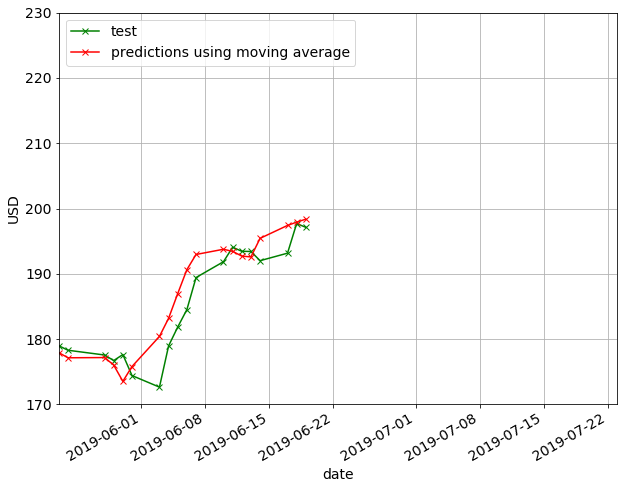

In [103]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = test.plot(x='date', y='est_N2', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using moving average'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2019, 5, 23), date(2019, 7, 23)])
ax.set_ylim([170, 230])